### Udacity Self-Driving Car Engineer Nanodegree


# Project 2: Advanced Lane Finding

**Input:** Video of a vehicle driving on a highway

**Output:** Annotated video with detected lane boudnaries, estimated lane curvature, and vehicle offset from center

     

<img src="./examples/example_output2.png" width=600 />

**Steps:**
* Camera calibration
* Distortionn correction
* Gradient and color thersholding
* Perspective transform to rectify the image
* Detecting lane pixels and fitting a polynomial 
* Detemining lane curvature and vehicle offset
* Warping detected lane boudaries back to the original image
* Visualizing lane boudaries and outputing lane curvature and vehicle offset



## Imports and Helper Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2


def show_image(image, bgr=False, gray=False):
    """
    Shows the image using matplotlib. 
    If the image is bgr, copies the image and converts 
    the color to rgb before showing
    """
    img = image
    if bgr and not gray:
        img = np.copy(image)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    if gray:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
        
    plt.show()
    

def show_images(im1, im2, title1=None, title2=None):
    """
    Shows two images side-by-side.
    """
    cmap = None
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    
    if len(im1.shape) == 2: cmap = "gray"
    ax1.imshow(im1, cmap=cmap)
    if title1: ax1.set_title(title1)

    if len(im2.shape) == 2: cmap = "gray"    
    ax2.imshow(im2, cmap=cmap)
    if title2: ax2.set_title(title2)

    plt.show()
    
    
def convert_to_gray(img, bgr=False):
    """
    Convert the input image to grayscale. 
    """
    if bgr: 
        return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else: 
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    
def convert_to_hls(img, bgr=False):
    """
    Converts the input image to HLS color space. 
    """
    if bgr: 
        return cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    else: 
        return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    


## Camera Calibration

In [2]:
def get_objpts(pattern_size):
    """
    Returns 3D object points for a given chessboard pattern size
    Pattern size must be a tuple (nx, ny)
    """
    nx, ny = pattern_size
    objpts = np.zeros((nx * ny, 3), np.float32)
    objpts[:, 0:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)
    return objpts


def camera_calibration(images_path, pattern_size):
    """ Calculates and returns camera matrix and distoriton cooeffients. 

    This function take the path to a folder where images 
    of the calibaration chessboard pattern are stored. 
    The images must have a naming pattern as "calibrationX.jpg", 
    where X is consequitive number. 

    The function reads the images, detects the chessboard corners, 
    setups correspondence points resulting from all images, and 
    calculates and returns camera matrix and distortion coefficietns. 


    Args: 
        images_path: path to the folder where calibration images are stored.
        pattern_size: size of the chessboard pattern as tupple (x, y)

    Returns: 
        Camera matrix and distortion coefficients, or raises a 
        RuntimeExceptions if unsuccessful. 
    """
    
    objpts = get_objpts(pattern_size)
    img_points = []
    obj_points = []

    image_size = (0, 0)

    fnames = glob.glob(images_path)
    for i, fname in enumerate(fnames):
        img = cv2.imread(fname)
        image_size = img.shape[1::-1]
        ret, corners = cv2.findChessboardCorners(img, pattern_size, None)
        if ret:
            cv2.drawChessboardCorners(img, pattern_size, corners, ret)
            img_points.append(corners)
            obj_points.append(objpts)

    ret, mtx, dist, _, _ = cv2.calibrateCamera(obj_points, 
                                              img_points, 
                                              image_size, 
                                              None, 
                                              None)
    if ret:
        return mtx, dist
    else:
        raise RuntimeError("Could not calibrate camera")


images_path = "./camera_cal/calibration*.jpg"
pattern_size = (9, 6)
mtx, dist_coeff = camera_calibration(images_path, pattern_size)
print("Camera matrix: \n", mtx)
print()
print("Distortion coefficients: \n", dist_coeff)

Camera matrix: 
 [[1.15777930e+03 0.00000000e+00 6.67111054e+02]
 [0.00000000e+00 1.15282291e+03 3.86128938e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients: 
 [[-0.24688775 -0.02373132 -0.00109842  0.00035108 -0.00258571]]


## Distortion Correction

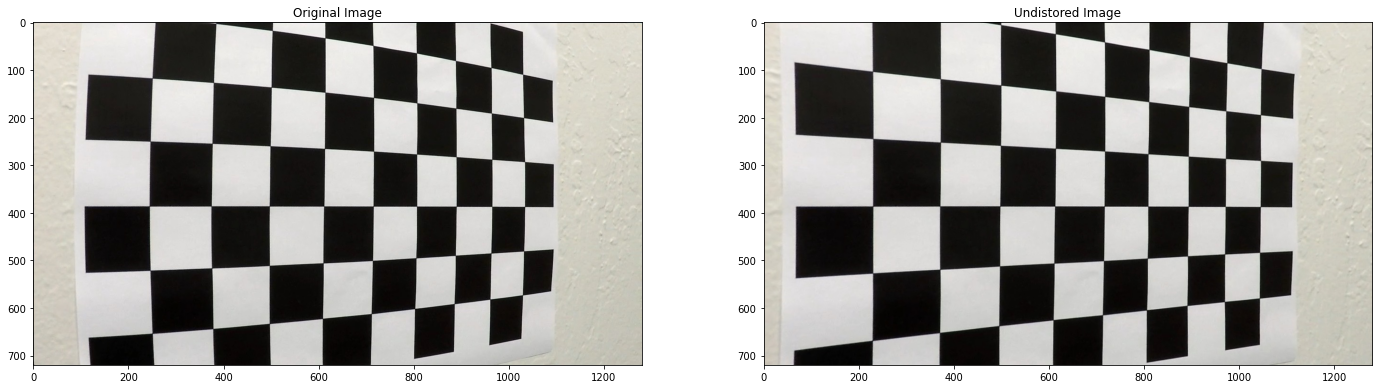

In [3]:
def correct_distortion(img, cam_matrix, dist_coeffs):
    """
    Corrects the image distortion and returns the undistored image.
    
    """
    return cv2.undistort(img, cam_matrix, dist_coeffs, None, cam_matrix)


image = plt.imread("./camera_cal/calibration5.jpg")
undistored = correct_distortion(image, mtx, dist_coeff)
show_images(image, undistored, "Original Image", "Undistored Image")



## Gradient and Color Thresholding

### Gradient Thresholding

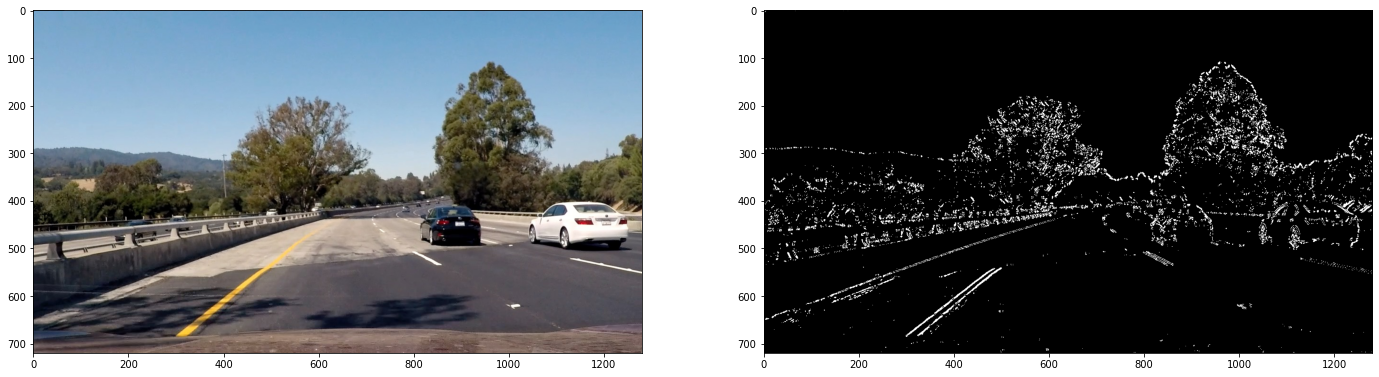

In [4]:
def abs_sobel_threshold(img, direction="x", thresh=(0, 255), ksize=3, bgr=False):
    """
    Applies the Sobel operator in the given direction and return 
    a binary image after applying the threshold. 
    """
    gray = convert_to_gray(img, bgr)
    s = None
    if direction=="x":
        s = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    else:  
        s = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
        
    abs_s = np.absolute(s)
    scaled_s = np.uint8(abs_s * 255 / np.max(abs_s))
    mask = np.zeros_like(gray)
    mask[(scaled_s >= thresh[0]) & (scaled_s <= thresh[1])] = 1
    return mask


def grad_mag_threshold(img, thresh=(0,255), ksize=3, bgr=False):
    """
    Applies Sobel operator to get the derivatives in x and y direction.
    Calculates the magnitude of the gradient for the input image, 
    applies the threshold, and returns the resulting binary image. 
    
    Args:
        img: the input image
        mag_thresh: the lower and upper threshold value for magnitude
                    of the gradient as a tuple (l, h)
        ksize: size of the Sobel kernel
        bgr: if the image is BGR format
        
    Returns: 
        Binary image, with 1 for every pixel with the magnitude of 
        gradient within threshold values.
    """
    gray = convert_to_gray(img, bgr) 
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    mag = np.sqrt(sx**2 + sy**2)
    mag_scaled = np.uint8(mag * 255 / np.max(mag))
    mask = np.zeros_like(gray)
    mask[(mag_scaled >= thresh[0]) & (mag_scaled <= thresh[1])] = 1
    return mask
    

def grad_dir_threshold(img, thresh=(-np.pi/2, np.pi/2), ksize=3, bgr=False):
    """
    Applies Sobel in x and y directions. Calculates the 
    direction of gradient. Applies the threshold and returns 
    the resulting binary image. 
    """
    gray = convert_to_gray(img, bgr)
    sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=ksize)
    abs_sx = np.absolute(sx)
    sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=ksize)
    grad_dir = np.arctan2(sy, abs_sx)
    mask = np.zeros_like(gray)
    mask[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return mask


fnames = glob.glob("./test_images/*.jpg")
image = plt.imread(fnames[2])
sx_binary = abs_sobel_threshold(image, direction="x", thresh=(20, 120), ksize=5)
sy_binary = abs_sobel_threshold(image, direction="y", thresh=(20, 120), ksize=5)
mag_binary = grad_mag_threshold(image, thresh=(30, 100), ksize=7)
dir_binary = grad_dir_threshold(image, thresh=(0.2, 0.6), ksize=7)

combined_grad = np.zeros((image.shape[:2]), np.uint8)
combined_grad[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

show_images(image, combined_grad)

### Color Thresholding

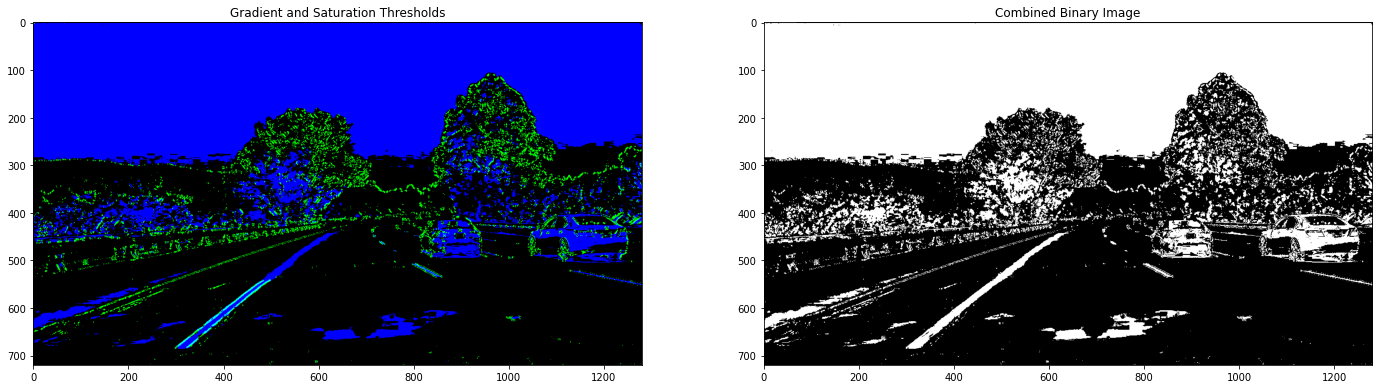

In [6]:
def saturation_threshold(img, thresh=(0, 255), bgr=False):
    """
    Converts the input image to HLS, applies the threshold
    to S channel, and reutrns the resulting binary image.
    """
    hls = convert_to_hls(image)
    s = hls[:, :, 2]
    mask = np.zeros_like(s)
    mask[(s >= thresh[0]) & (s <= thresh[1])] = 1
    return mask


def hue_threshold(img, thresh=(0, 255), bgr=False):
    """
    Converts the input image to HLS, applies the threshold
    to H channel, and reutrns the resulting binary image.
    
    Note: Not very useful. You better only use S channel
    """
    hls = convert_to_hls(image)
    h = hls[:, :, 0]
    mask = np.zeros_like(s)
    mask[(h >= thresh[0]) & (h <= thresh[1])] = 1
    return mask


sat_binary = saturation_threshold(image, (100, 255))

combined_binary = np.zeros_like(sat_binary)
combined_binary[(combined_grad == 1) | (sat_binary == 1)] = 1

combined_color = np.dstack((np.zeros_like(combined_grad), combined_grad, sat_binary)) * 255

show_images(combined_color, combined_binary, "Gradient and Saturation Thresholds", "Combined Binary Image")



## Perspective Transformation (rectify image)

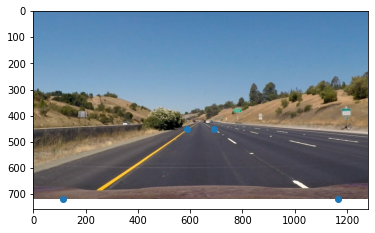

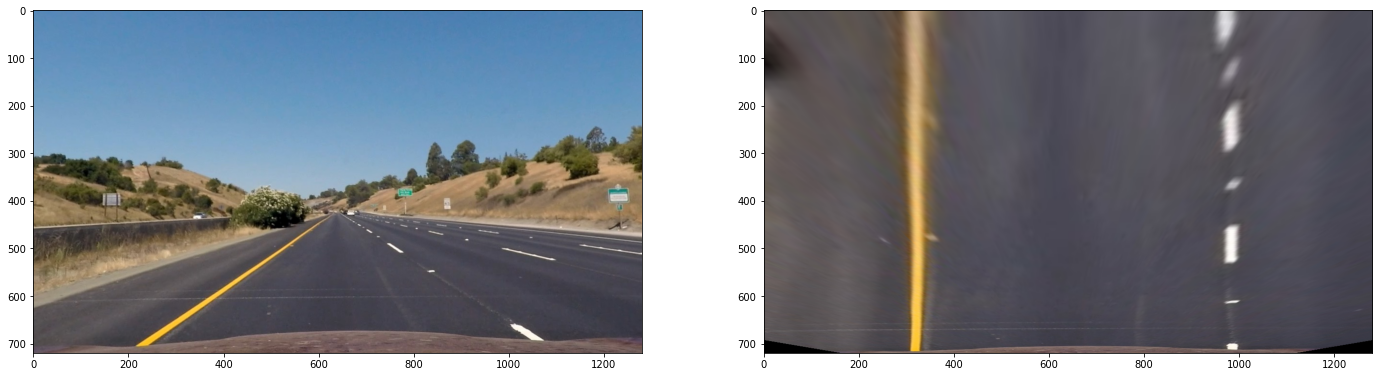

In [16]:
def get_warp_matrix(image_size=(1280, 720), 
                    top_y=450, 
                    top_width=105, 
                    bottom_width=1050, 
                    dst_offset=250):
    
    """
    Sets up and returns the warp matrix for the birds eye view. 
    The assumption is that an isosceles trapzoid will be warped
    into a rectangle. The trapezoid is centered on the image. The 
    input parameters top_y, top_width, and bottom_width define the 
    trapezoid. 
    The default values for the input parameters were determined by
    checking multiple images of the straight roads. 
    """
    
    width, height = image_size
    
    top_left_x = (width - top_width) // 2
    top_right_x = (width + top_width) // 2
    
    bottom_left_x = (width - bottom_width) // 2
    bottom_right_x = (width + bottom_width) // 2
    
    src = np.float32([[bottom_left_x, height], 
                      [bottom_right_x, height], 
                      [top_right_x, top_y], 
                      [top_left_x, top_y]])
    
    dst = np.float32([[dst_offset, height], 
                      [width - dst_offset, height], 
                      [width - dst_offset, 0], 
                      [dst_offset, 0]])
    
    return src, dst, cv2.getPerspectiveTransform(src, dst)

    
def rectify(image, warp_matrix, img_size=(1280, 720)):
    """
    Applies the warp matrix to the image and returns the 
    perspective transformed Image.
    """
    return cv2.warpPerspective(image, warp_matrix, img_size, flags=cv2.INTER_LINEAR)


image = plt.imread(fnames[7])
image_undist = correct_distortion(image, mtx, dist_coeff)

src, dst, warp_matrix = get_warp_matrix()

plt.imshow(image)
plt.scatter(src[:, 0], src[:, 1])
plt.show

warped1 = rectify(image_undist, warp_matrix)
show_images(image_undist, warped1)



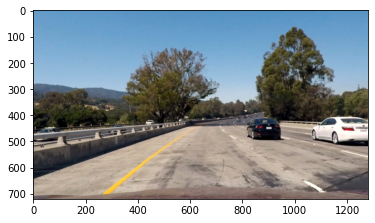

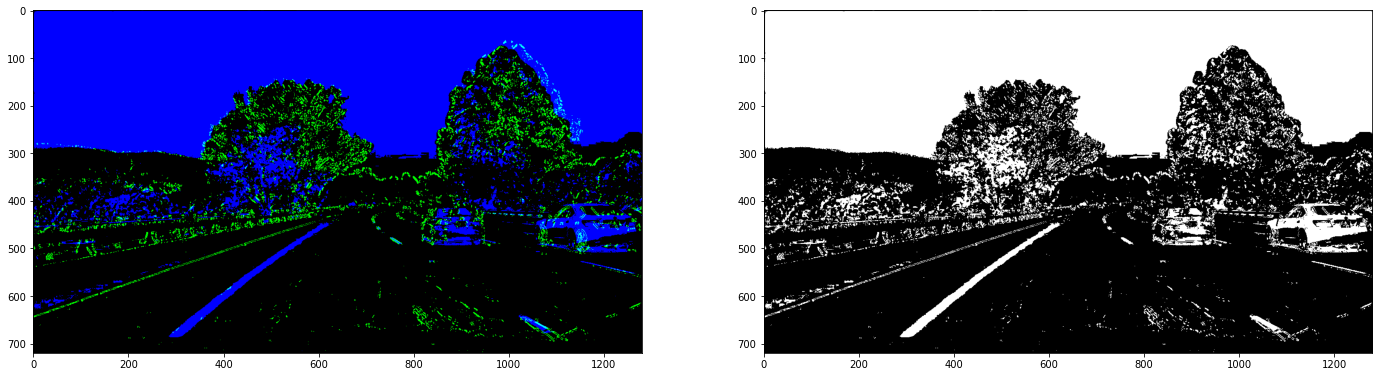

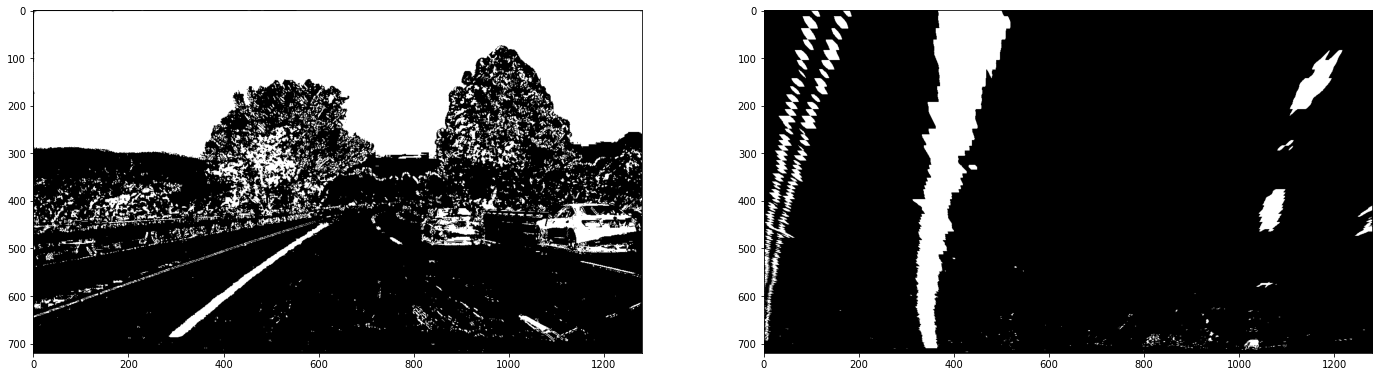

In [23]:

def apply_thresholds(image):
    """
    Applies a different gradient thresholds combined with 
    color threshold on Saturation and returns the resulting
    combined binary image and a combined color image. 
    
    TODO: This function should get different parameters 
    over a dictionary. 
    """
    sx_binary = abs_sobel_threshold(image, direction="x", thresh=(20, 120), ksize=5)
    sy_binary = abs_sobel_threshold(image, direction="y", thresh=(20, 120), ksize=5)
    mag_binary = grad_mag_threshold(image, thresh=(30, 100), ksize=7)
    dir_binary = grad_dir_threshold(image, thresh=(0.2, 0.6), ksize=7)

    combined_grad = np.zeros((image.shape[:2]), np.uint8)
    combined_grad[((sx_binary == 1) & (sy_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    sat_binary = saturation_threshold(image, (100, 255))

    combined_binary = np.zeros_like(sat_binary)
    combined_binary[(combined_grad == 1) | (sat_binary == 1)] = 1

    combined_color = np.dstack((np.zeros_like(combined_grad), combined_grad, sat_binary)) * 255
    
    return combined_binary, combined_color



image = plt.imread(fnames[3])
image_undist = correct_distortion(image, mtx, dist_coeff)
show_image(image_undist)

combined_binary, combined_color = apply_thresholds(image_undist)
show_images(combined_color, combined_binary)


_, _, warp_matrix = get_warp_matrix()
binary_warped = rectify(combined_binary, warp_matrix)
show_images(combined_binary, binary_warped)



## Detecting Lane Pixels and Fitting a Polynomial




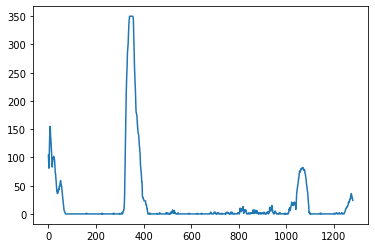

In [24]:
histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
plt.plot(histogram)

### Detecting the Lane Lines

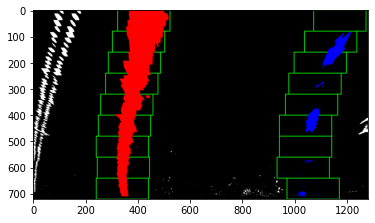

In [27]:
# input: bwarped


def find_lanes_sliding_window(bwarped_img, nwindows=9, margin=100, minpix=50, debug=False):
    """
    Performs a sliding window algorithm on the input binary rectified image
    and returns the (y, x) coordinate of pixels belonging to each left and
    right lanes. Also return the offset of lane midpiont from imge midpoint
    in pixels. 
    
    Args:
        bwarped_img: 
            The binary rectified image of the road (warped to brid eye view).
        nwindows:   
            Number of windows for the sliding window algorithm. 
        margin:      
            Each window has the width 2*margin and is centered around 
            the lane line. (The windows is actually centered around its 
            base which is adjusted to be aligned with the lane line). 
        minpix:     
            If the number of nonzero pixels inside a window is higher than 
            minpix, the x coordinated of the base for the next window is 
            calculated to be the mean of x coordinate of nonzero pixels in 
            current window.
        debug:      
            If True, an image of windows and detected lane pixels overlaid 
            over input image is returned.
            
    Returns: 
        Two arrays, for left lane and for right lane, of shape 
        (n, 2) containing the (y, x) coordinate of each pixel 
        belonging to the lane. 
        
        The pixel value of the offset of the center point of lane 
        from the middle of the image. The center point of lane is 
        the middle point between the x coordinate of the left and
        right lane
        
        If debug is true, also an image depicting the detected lanes 
        is returned. 
        
    """
    
    # find the x coordinate of the base of left and right lane
    histogram = np.sum(bwarped[bwarped.shape[0] // 2:, :], axis=0)
    midpoint = histogram.shape[0] // 2
    base_left_x = np.argmax(histogram[:midpoint])
    base_right_x = midpoint + np.argmax(histogram[midpoint:])

    # find the offset of the lane center from midpoint of the image
    lane_center = (base_left_x + base_right_x) // 2
    offset_from_middle_of_image =  lane_center - (bwarped.shape[1] // 2)

    # window height for sliding window
    w_height = bwarped.shape[0] // nwindows

    # used for positioning the next window
    current_base_left_x = base_left_x
    current_base_right_x = base_right_x

    left_lane_pixels_list = [] 
    right_lane_pixels_list = []

    if debug:
        out_image = np.dstack((bwarped, bwarped, bwarped))*255
        
    for w in range(nwindows):
        # get the coordinates of the left and right window
        w_bottom_y = bwarped.shape[0] - (w * w_height)
        w_top_y = bwarped.shape[0] - (w + 1) * w_height
        left_w_lx = current_base_left_x - margin 
        left_w_rx = current_base_left_x + margin
        right_w_lx = current_base_right_x - margin
        right_w_rx = current_base_right_x + margin

        if debug:
            # draw widow
            cv2.rectangle(out_image, (left_w_lx, w_top_y), 
                          (left_w_rx, w_bottom_y), (0, 255, 0), 2)
            cv2.rectangle(out_image, (right_w_lx, w_top_y), 
                          (right_w_rx, w_bottom_y), (0, 255, 0), 2)

        # collect the coordinates of nonzero pixels in the window
        left_win = bwarped[w_top_y:w_bottom_y, left_w_lx:left_w_rx]
        right_win = bwarped[w_top_y:w_bottom_y, right_w_lx:right_w_rx]
        
        left_nz = left_win.nonzero()
        left_nzy = left_nz[0] + w_top_y
        left_nzx = left_nz[1] + left_w_lx
        
        right_nz = right_win.nonzero()
        right_nzy = right_nz[0] + w_top_y
        right_nzx = right_nz[1] + right_w_lx
 
        left_lane_pixels_list.append(np.array([left_nzy, left_nzx]).T)
        right_lane_pixels_list.append(np.array([right_nzy, right_nzx]).T)

        # move window horizontally to follow the lane
        if len(left_nzx) > minpix: 
            current_base_left_x = np.int(np.mean(left_nzx))
        if len(right_nzx) > minpix:
            current_base_right_x = np.int(np.mean(right_nzx))

    # create one array containing all lane coordinates for each lane
    left_lane_pixels = np.vstack(left_lane_pixels_list)
    right_lane_pixels = np.vstack(right_lane_pixels_list)

    if debug:    
        # draw detected lane pixels
        out_image[left_lane_pixels[:, 0], left_lane_pixels[:, 1], :] = (255, 0, 0)
        out_image[right_lane_pixels[:, 0], right_lane_pixels[:, 1], :] = (0, 0, 255)

    if debug: 
        return (left_lane_pixels, 
                right_lane_pixels, 
                offset_from_middle_of_image, 
                out_image)
    else:
         return (left_lane_pixels, 
                 right_lane_pixels, 
                 offset_from_middle_of_image)
            

    
bwarped = np.copy(binary_warped)   
left_lane_pixels, right_lane_pixels, \
    offset_from_middle_of_image, \
        out_image = find_lanes_sliding_window(bwarped, debug=True)
show_image(out_image)

### Fitting Polynemial

In [ ]:
lefty, leftx = np.split(left_lane_pixels, 2, axis=1)
righty, rightx = np.split(right_lane_pixels, 2, axis=1)


left_fit_pix = np.polyfit(lefty.squeeze(), leftx.squeeze(), 2)
right_fit_pix = np.polyfit(righty.squeeze(), rightx.squeeze(), 2)

print(left_fit_pix)
print(right_fit_pix)

plotys = np.linspace(0, bwarped.shape[0] - 1, bwarped.shape[0])
plotleftxs = np.polyval(left_fit_pix, plotys)
plotrightxs = np.polyval(right_fit_pix, plotys)

plt.imshow(out_image)
plt.plot(plotleftxs, plotys, color="yellow")
plt.plot(plotrightxs, plotys, color="yellow")


### Determining the Curvature

$$ \LARGE R_{curve} = \frac{[1 + (\frac{dx}{dy})^2]^{3/2}}{|\frac{d^2x}{dy^2}|} $$

$$ \LARGE R_{curve} = \frac{(1 + (2Ay + B)^2)^{3/2}}{\left |2A \right |} $$

In [ ]:


my = 30/720 # scale for y axis in meter per pixel
mx = 3.7/780  # scale for x axis in meter per pixel

yeval = np.max(plotys)
yeval_real = my * yeval

l_a_pix = left_fit_pix[0]
l_a_real = (mx / my**2) * l_a_pix
l_b_pix = left_fit_pix[1]
l_b_real = (mx/my) * l_b_pix
l_c_pix = left_fit_pix[2]
l_curv_real = np.power((1 + (l_a_real * yeval_real + l_b_real)**2), 1.5) / np.absolute(2 * l_a_real)
print("Left lane curvature: ", l_curv_real)

r_a_pix = right_fit_pix[0]
r_a_real = (mx / my**2) * r_a_pix
r_b_pix = right_fit_pix[1]
r_b_real = (mx/my) * r_b_pix
r_c_pix = right_fit_pix[2]
r_curv_real = np.power((1 + (2 * r_a_real * yeval_real + r_b_real)**2), 1.5) / np.absolute(2 * r_a_real)
print("Right lane curvature: ", r_curv_real)

print("Offset in pixels: ", offset_from_middle_of_image)
offset_direction = "right" if offset_from_middle_of_image > 0 else "left"
vehicle_offset = mx * offset_from_middle_of_image
print(f"Vehicle is {abs(vehicle_offset):2.2f}m {offset_direction} of lane center")



## Warping Detected Lanes Back to the Image

In [ ]:
m_inv = np.linalg.inv(warp_matrix)
warped_back = cv2.warpPerspective(out_image, m_inv, (1280, 720))
show_image(warped_back)

In [ ]:
warp_zero = np.zeros_like(bwarped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

pts_left = np.array([np.transpose(np.vstack([plotleftxs, plotys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([plotrightxs, plotys])))])
pts = np.hstack((pts_left, pts_right))

cv2.fillPoly(color_warp, np.int_(pts), (0, 255, 0))

unwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0]))
undist = correct_distortion(image, mtx, dist_coeff)
result = cv2.addWeighted(undist, 1., unwarp, 0.3, 0)
show_images(color_warp, result)


## Complete Pipeline



In [ ]:
# Camera Calibration
# Prepare perspective transform matrix
# For each image in test images: 
#   - correct distortion
#   - apply gradient and color threshold
#   - rectify image
#   - detect lane pixels and fit polynomial
#   - determine curvature and offset
#   - warp back detected lane onto the image
#   - output lane cruvature and vehicle offset



<br>

## Notes and Schmierpapier

In [ ]:
np.mgrid[0:3, 0:4].T.reshape(-1)

In [ ]:
data1, data2, data3, data4 = np.random.randn(4, 100)

In [ ]:

image = mpimg.imread(fnames[7])
pts = np.array([[330,620],[950,620],[692,450],[587,450]])
plt.imshow(image)
plt.plot(640, 570, "og", markersize=10)
plt.scatter(pts[:, 0], pts[:, 1], marker="x", color="red", s=200)
plt.show()

In [ ]:
binary = np.random.randint(2, size=(4,5))
print(binary)
print("\n----------\n")


fig, ax = plt.subplots()
ax.set_yticks(np.arange(5))
ax.invert_yaxis()
ax.xaxis.tick_top()
ax.imshow(binary)


In [ ]:
nonzeros = binary.nonzero()
nzy, nzx = nonzeros
nzx

In [ ]:
a = np.array([nzy, nzx])
a

In [ ]:
b = a.T
b

In [ ]:
ys, xs = np.split(b, 2, axis=1)
ys.squeeze().shape

In [ ]:
a = np.empty((0, 2))
b = np.array([[1, 2], [2, 3]])
c = np.arange(12).reshape((-1, 2))

In [ ]:
a = np.vstack((a, b))

In [ ]:
d = np.vstack((a, c))

In [ ]:
d

In [ ]:
# Create an image to draw the lines on
warp_zero = np.zeros_like(bwarped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x and y points into usable format for cv2.fillPoly()
pts_left = np.array([np.transpose(np.vstack([plotleftxs, plotys]))])
pts_right = np.array([np.flipud(np.transpose(np.vstack([plotrightxs, plotys])))])
pts = np.hstack((pts_left, pts_right))
print(pts.shape)

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

show_image(color_warp)


# Warp the blank back to original image space using inverse perspective matrix (Minv)
newwarp = cv2.warpPerspective(color_warp, m_inv, (image.shape[1], image.shape[0])) 
# Combine the result with the original image
undist = correct_distortion(image, mtx, dist_coeff)
result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
plt.imshow(result)